# fbprophet과 rf 모델을 활용한 인공지능 비트 트레이더 경진대회 베이스라인 코드

* 사용 모델: fbprophet, rnn 

# 1. Library Import

In [1]:
# !pip install scikit-learn

In [2]:
import gc
import math
import os.path
import time
from datetime import timedelta, datetime
from dateutil import parser
from tqdm import tqdm
import copy
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf

In [3]:
# import packages
import pandas as pd
import numpy as np
import os
import random
import pickle
from IPython.display import Image
import seaborn as sns
import shutil

import matplotlib.pylab as plt
import warnings; warnings.filterwarnings("ignore")
from matplotlib import font_manager, rc
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler # 0~1 사이값으로 스케일링

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import mean_squared_error

In [4]:
#determinism seed
#random
SEED = 42

# random seed 
def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

In [5]:
set_seeds(SEED)

# 2. 데이터 불러오기

## 1) read_csv

In [6]:
data_path = os.getenv('HOME') + '/dacon/ModuWay/baseline/data' # 다름! 변경해줘야함
# data_path = os.getenv('HOME') + '/ModuWay/data'  
train_x_df = pd.read_csv(data_path  + "/train_x_df.csv")
train_y_df = pd.read_csv(data_path  + "/train_y_df.csv")
test_x_df = pd.read_csv(data_path  + "/test_x_df.csv")

In [7]:
# 상관 분석 - 각 변수간의 연관성이 1에 가까울수록 높음
corr = train_x_df.corr(method='pearson')
corr

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
sample_id,1.000000e+00,-1.233663e-14,4.278576e-03,-0.011692,-0.011690,-0.011662,-0.011676,-0.000407,0.010186,0.009696,-0.000393,0.009447
time,-1.233663e-14,1.000000e+00,1.804201e-16,-0.012273,-0.012346,-0.012248,-0.012289,-0.000277,-0.000464,-0.000708,-0.000444,-0.000394
coin_index,4.278576e-03,1.804201e-16,1.000000e+00,-0.010498,-0.010721,-0.010341,-0.010520,0.006909,0.000136,0.010454,0.006393,-0.000206
open,-1.169152e-02,-1.227325e-02,-1.049803e-02,1.000000,0.998631,0.999254,0.999071,0.009158,0.025290,0.022769,0.004867,0.019132
high,-1.169041e-02,-1.234571e-02,-1.072102e-02,0.998631,1.000000,0.997830,0.998898,0.014944,0.033986,0.032518,0.011817,0.029751
low,-1.166162e-02,-1.224846e-02,-1.034080e-02,0.999254,0.997830,1.000000,0.999315,0.002101,0.014780,0.011092,0.001434,0.012224
close,-1.167617e-02,-1.228935e-02,-1.052042e-02,0.999071,0.998898,0.999315,1.000000,0.008074,0.024175,0.021432,0.007229,0.022276
volume,-4.068947e-04,-2.768361e-04,6.909391e-03,0.009158,0.014944,0.002101,0.008074,1.000000,0.420857,0.573042,0.794751,0.372958
quote_av,1.018637e-02,-4.641555e-04,1.357815e-04,0.025290,0.033986,0.014780,0.024175,0.420857,1.000000,0.826307,0.344711,0.920649
trades,9.695827e-03,-7.075427e-04,1.045373e-02,0.022769,0.032518,0.011092,0.021432,0.573042,0.826307,1.000000,0.466903,0.754661


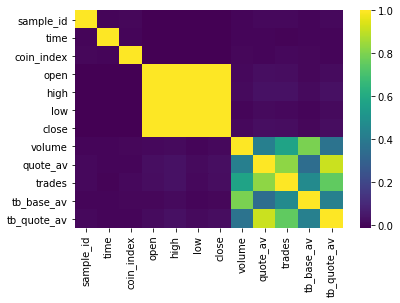

In [8]:
sns.heatmap(corr, cmap='viridis')
plt.show()

<Figure size 720x504 with 0 Axes>

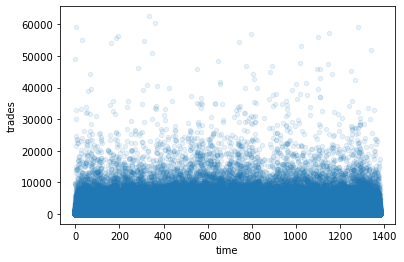

In [10]:
# 시간 흐름별 trade양 
fig = plt.figure(figsize=(10,7))
train_x_df.plot(x='time', y ='trades', kind='scatter', alpha=0.1)
fig.tight_layout()

## 2) numpy arrary로 변환하기

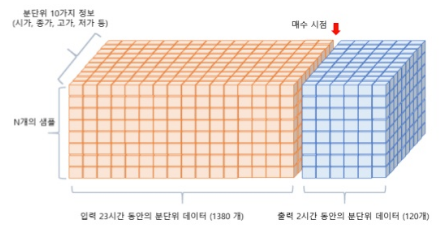

In [11]:
def df2d_to_array3d(df_2d):
    # 입력 받은 2차원 데이터 프레임을 3차원 numpy array로 변경하는 함수
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d

In [12]:
train_x_array = df2d_to_array3d(train_x_df)
train_y_array = df2d_to_array3d(train_y_df)
test_x_array = df2d_to_array3d(test_x_df)

In [13]:
print(f'''
train_x_array {train_x_array.shape}
train_y_array {train_y_array.shape}
test_x_array {test_x_array.shape}
''')


train_x_array (7362, 1380, 10)
train_y_array (7362, 120, 10)
test_x_array (529, 1380, 10)



## 3) 샘플 확인하기

In [25]:
def plot_series(x_series, y_series, index):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
             y_series, label = 'output_series')
    plt.title("sample_id=" + str(index), fontsize=18)
    plt.axhline(1, c = 'red')
    plt.legend()

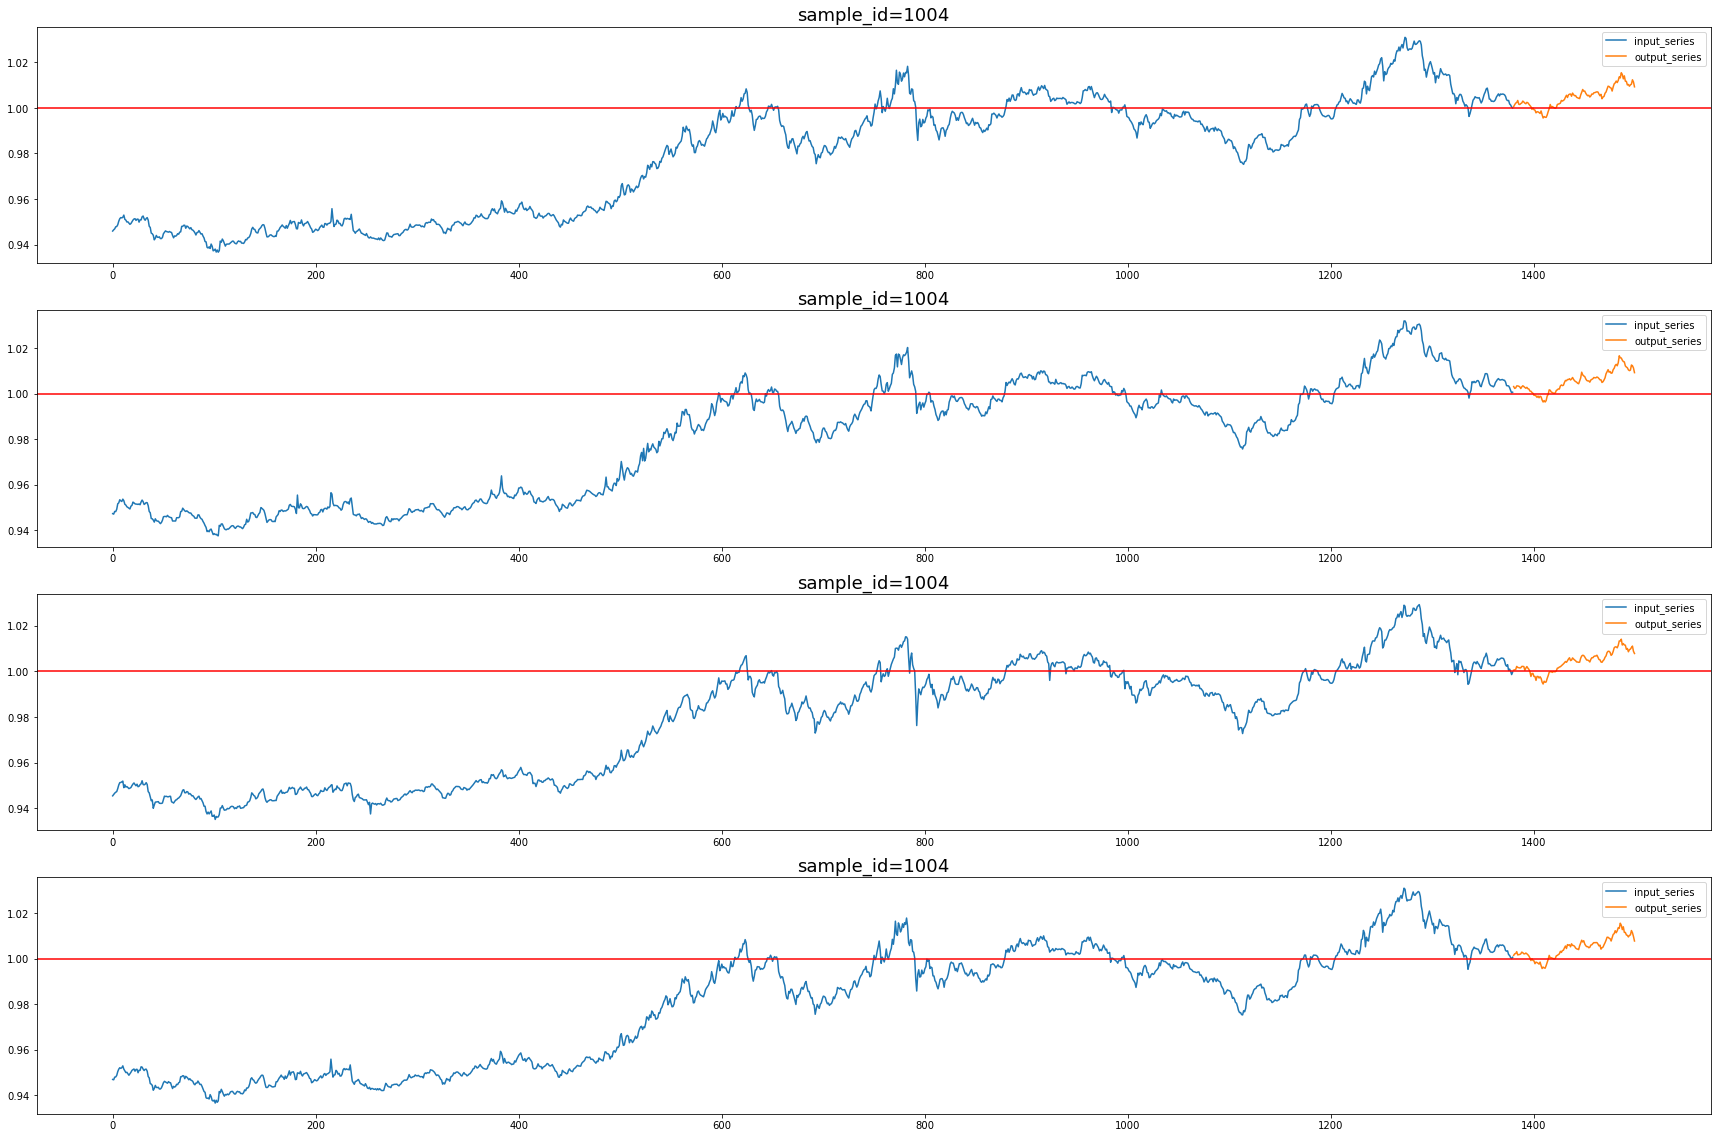

In [31]:
# sample_id에 해당하는 sample의 분단위변동 정보 시각화
# open, high, low, close
plt.figure(figsize = (30, 20)) 

plt.subplot(411)
plot_series(train_x_array[idx,:,1], train_y_array[idx,:,1], idx)

plt.subplot(412)
plot_series(train_x_array[idx,:,2], train_y_array[idx,:,2], idx)

plt.subplot(413)
plot_series(train_x_array[idx,:,3], train_y_array[idx,:,3], idx)

plt.subplot(414)
plot_series(train_x_array[idx,:,4], train_y_array[idx,:,4], idx)

plt.show()

In [21]:
idx = 1004
sample_trades = pd.DataFrame(train_x_array[idx, :, 7], columns=['trades'])
sample_trades.head()

,trades
0,1.087181
1,0.928920
2,1.059657
3,1.052776
4,1.444987


In [22]:
sample_trades['time'] = range(0, 1380)

In [23]:
sample_trades.head()

,trades,time
0,1.087181,0
1,0.928920,1
2,1.059657,2
3,1.052776,3
4,1.444987,4


<Figure size 720x504 with 0 Axes>

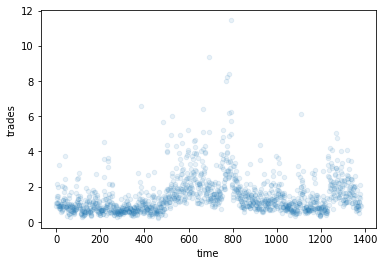

In [24]:
# 특정 sample id의 시간 흐름별 trade양 
fig = plt.figure(figsize=(10,7))
sample_trades.plot(x='time', y ='trades', kind='scatter', alpha=0.1)
fig.tight_layout()

600 ~ 800 사이와, 1200 ~ 1400 사이에서 거래량이 많음을 알 수 있다. 

<function matplotlib.pyplot.show(close=None, block=None)>

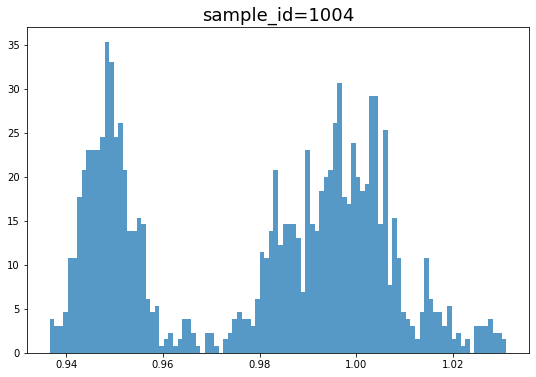

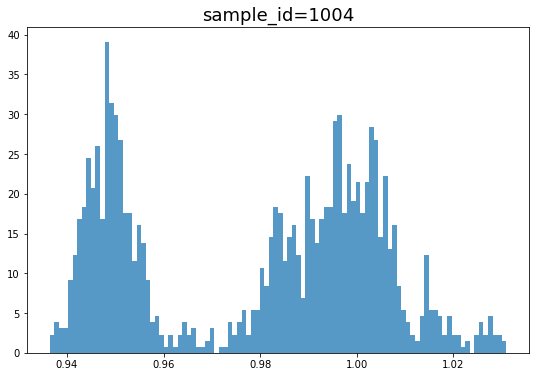

In [27]:
# open
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(train_x_df[train_x_df['sample_id']==idx].open, 100, density=True, alpha=0.75)
plt.title("sample_id=" + str(idx), fontsize=18)

# close
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(train_x_df[train_x_df['sample_id']==idx].close, 100, density=True, alpha=0.75)
plt.title("sample_id=" + str(idx), fontsize=18)

plt.show

# 3. 모델 훈련하기  - RF

## 2) validation set 훈련하기

### <1> validation 데이터 생성하기

In [32]:
# train 데이터 상단의 300개 샘플로 validation set를 구성하여 학습 및 추론
valid_x_df = train_x_df[train_x_df.sample_id < 300]
valid_y_df = train_y_df[train_y_df.sample_id < 300]

valid_x_array = df2d_to_array3d(valid_x_df)
valid_y_array = df2d_to_array3d(valid_y_df)
valid_pred_array = np.zeros([300, 120])

In [33]:
valid_x_df.shape # 차원 조절이 안된 데이터 

(414000, 12)

In [34]:
valid_y_df.shape # 차원 조절이 안된 데이터 

(36000, 12)

In [51]:
valid_x_array[1, :, 1].shape # 1380행이므로, 1380분에 대한 라벨 데이터 

(1380,)

In [52]:
valid_y_array[1, :, 1].shape # 120행이므로, 120분에 대한 라벨 데이터 

(120,)

In [53]:
a = [0, 1, 2]
a[:-1], a[-1:]

([0, 1], [2])

In [67]:
# split 
open_valid_x = valid_x_array[1, :-120, 1].reshape(1, -1)
open_valid_y = valid_x_array[1, -120:, 1].reshape(1, -1)

In [68]:
open_valid_x.shape, open_valid_y.shape

((1, 1260), (1, 120))

In [71]:
open_valid_test_x = valid_x_array[1, 120:, 1].reshape(1, -1)
open_valid_test_y = valid_y_array[1, :, 1].reshape(1, -1)

In [72]:
open_valid_test_x.shape, open_valid_test_y.shape

((1, 1260), (1, 120))

In [73]:
# sc = MinMaxScaler()
# open_sc = sc.fit_transform(open_arr)

In [74]:
# open_x_df = pd.DataFrame(open_x_arr, columns=['open'])
# open_y_df = pd.DataFrame(open_x_arr, columns=['open'])

### <2> 학습 및 추론하기

sklearn.preprocessing의 StandardScaler, MinMaxScaler 나 PCA클래스, 그리고 텍스트의 Feature Vectorization 클래스들(CountVectorizer, TFIDF등) 모드 fit()과 transform()을 같이 이용

In [75]:
from sklearn.ensemble import RandomForestRegressor

rf_model= RandomForestRegressor(bootstrap=True, n_estimators=30, n_jobs=1, random_state=SEED, verbose=0) #SEED값에 따라 같은 모델나오게함
rf_model.fit(open_valid_x, open_valid_y)

RandomForestRegressor(n_estimators=30, n_jobs=1, random_state=42)

In [76]:
rf_pred = rf_model.predict(open_valid_test_x)

In [78]:
rf_pred.shape

(1, 120)

In [77]:
print(mean_squared_error(open_valid_test_y, rf_pred))

0.00021264047710734736


In [85]:
rf_pred

array([[1.00720799, 1.00720799, 1.00714517, 1.00755429, 1.00742841,
        1.00705063, 1.00607491, 1.00607491, 1.00553989, 1.00468993,
        1.00415492, 1.00513065, 1.00412333, 1.00409186, 1.00305319,
        1.00295877, 1.00248659, 1.00330496, 1.00317907, 1.00264394,
        1.00311613, 1.00440669, 1.0033679 , 1.00424933, 1.0037142 ,
        1.00280142, 1.00273836, 1.00276995, 1.00390303, 1.00446963,
        1.00506771, 1.00557125, 1.0045011 , 1.00598049, 1.00588608,
        1.00616932, 1.00616932, 1.0049417 , 1.0049417 , 1.00591755,
        1.00667298, 1.00648403, 1.00613785, 1.01000941, 1.00881326,
        1.00793195, 1.00793195, 1.00821531, 1.00843561, 1.00884485,
        1.00796354, 1.00670433, 1.00768018, 1.00793195, 1.00749135,
        1.00742841, 1.00755429, 1.00594902, 1.00557125, 1.00462699,
        1.00339937, 1.00327349, 1.0045011 , 1.00481582, 1.002581  ,
        0.98819637, 0.9653132 , 0.969531  , 0.97966635, 0.97780919,
        0.97576326, 0.9876613 , 0.99021089, 0.98

In [95]:
reshape_rf_pred = rf_pred.reshape(-1, 1)
rf_pred_df = pd.DataFrame(reshape_rf_pred, columns = ['open'])
rf_pred_df.head()

,open
0,1.007208
1,1.007208
2,1.007145
3,1.007554
4,1.007428


In [96]:
rf_pred_df['time'] = range(0, 120)
rf_pred_df.head()

,open,time
0,1.007208,0
1,1.007208,1
2,1.007145,2
3,1.007554,3
4,1.007428,4


In [98]:
reshape_open_valid_test_y = open_valid_test_y.reshape(-1, 1)
open_valid_test_y_df = pd.DataFrame(reshape_open_valid_test_y, columns = ['open'])
open_valid_test_y_df.head()

,open
0,1.000504
1,0.999654
2,0.999559
3,1.000441
4,0.999622


In [99]:
open_valid_test_y_df['time'] = range(0, 120)
open_valid_test_y_df.head()

,open,time
0,1.000504,0
1,0.999654,1
2,0.999559,2
3,1.000441,3
4,0.999622,4


Text(0.5, 0, 'Time - true')

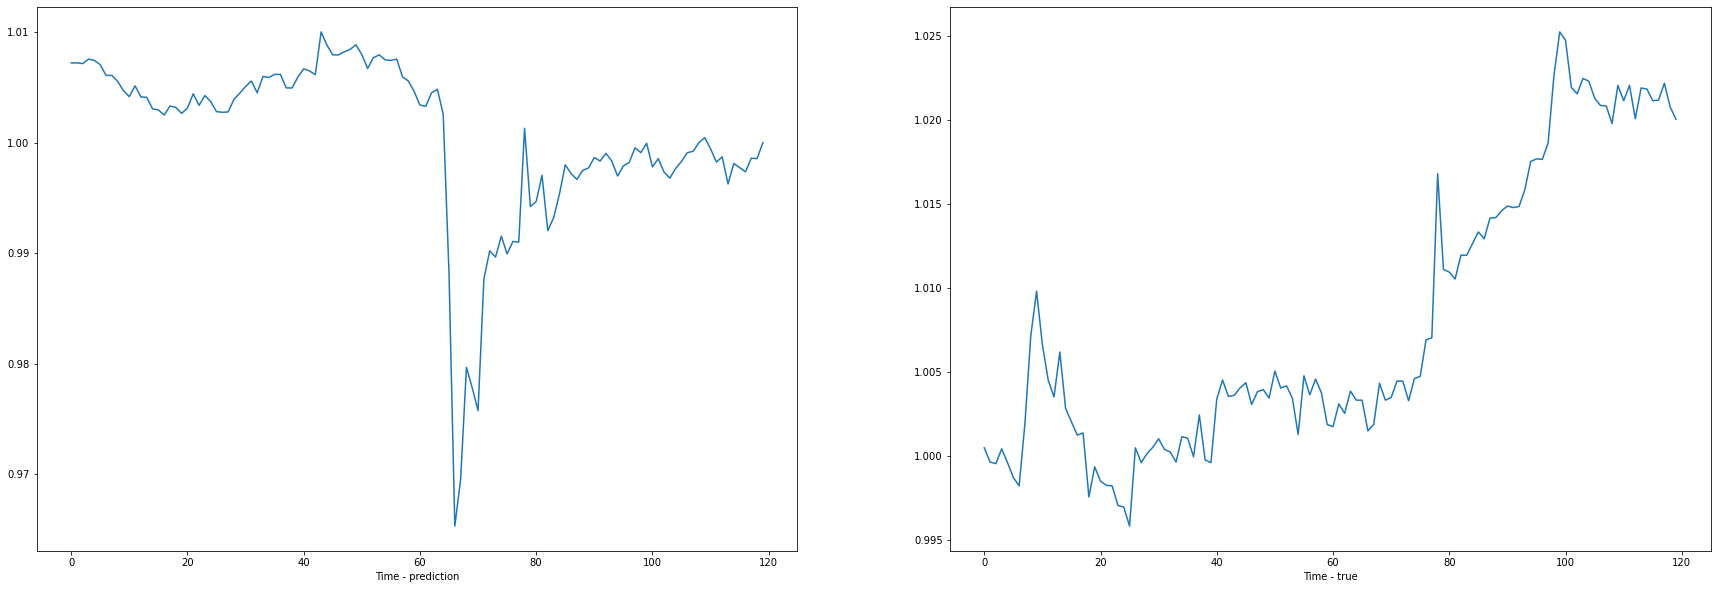

In [105]:
# open, high, low, close
plt.figure(figsize = (30, 10)) 

plt.subplot(121)
plt.plot(rf_pred_df['time'], rf_pred_df['open'])
plt.xlabel('Time - prediction', fontsize = 18)

plt.subplot(122)
plt.plot(open_valid_test_y_df['time'], open_valid_test_y_df['open'])
plt.xlabel('Time - true', fontsize = 18)

### set 구성 
valid만 

valid_x -> 1260, 120 
1260 *1 => 120*1(label)

-> fit 

fit한거로 predict 
valid_x -> 1260

valid_y -> 120

### <3> valid_pred_array 로부터 buy_quantity, sell_time 구하기

In [131]:
def array_to_submission(x_array, pred_array):
    # 입력 x_arrry와 출력 pred_arry를 통해서 
    # buy_quantitiy와 sell_time을 결정
    submission = pd.DataFrame(np.zeros([pred_array.shape[0],2], np.int64),
                columns = ['buy_quantity', 'sell_time'])
    submission = submission.reset_index()
    submission.loc[:, 'buy_quantity'] = 0.5
    
    buy_price = []
    for idx, sell_time in enumerate(np.argmax(pred_array, axis = 1)):
        buy_price.append(pred_array[idx, sell_time])
    buy_price = np.array(buy_price)
    # 115% 이상 상승한하고 예측한 sample에 대해서만 100% 매수
    submission.loc[:, 'buy_quantity'] = (buy_price > 1.08) * 1
    # 모델이 예측값 중 최대 값에 해당하는 시간에 매도
    submission['sell_time'] = np.argmax(pred_array, axis = 1)
    submission.columns = ['sample_id','buy_quantity', 'sell_time']
    return submission

In [132]:
valid_submission = array_to_submission(valid_x_array, valid_pred_array)

In [133]:
valid_submission

,sample_id,buy_quantity,sell_time
0,0,0,36
1,1,1,24
2,2,0,44
3,3,0,76
4,4,0,95
...,...,...,...
295,295,0,35
296,296,0,1
297,297,1,19
298,298,0,25


In [134]:
# 전체 300가지 sample에 대해
# 9가지 case에서 115% 이상 상승한다고 추론함.
valid_submission.buy_quantity.value_counts()

0    270
1     30
Name: buy_quantity, dtype: int64

### <4> 투자 후 금액 계산하기

In [135]:
def df2d_to_answer(df_2d):
    # valid_y_df로부터
    # open 가격 정보가 포함된
    # [샘플 수, 120분] 크기의 
    # 2차원 array를 반환하는 함수
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    sample_index = df_2d.sample_id.value_counts().index
    array_2d = df_2d.open.values.reshape([sample_size, time_size])
    sample_index = list(sample_index)
    return array_2d, sample_index


def COIN(y_df, submission, df2d_to_answer = df2d_to_answer):
    # 2차원 데이터프레임에서 open 시점 데이터만 추출하여 array로 복원
    # sample_id정보를 index에 저장
    y_array, index = df2d_to_answer(y_df)
    
    # index 기준으로 submission을 다시 선택
    submission = submission.set_index(submission.columns[0])
    submission = submission.iloc[index, :]    
    
    # 초기 투자 비용은 10000 달러
    total_momey      = 10000 # dolors
    total_momey_list = []
    
    # 가장 처음 sample_id값
    start_index = submission.index[0]
    for row_idx in submission.index:
        sell_time  = submission.loc[row_idx, 'sell_time']
        buy_price  = y_array[row_idx - start_index, 0]
        sell_price = y_array[row_idx - start_index, sell_time]
        buy_quantity = submission.loc[row_idx, 'buy_quantity'] * total_momey
        residual = total_momey - buy_quantity
        ratio = sell_price / buy_price
        total_momey = buy_quantity * ratio * 0.9995 * 0.9995 + residual        
        total_momey_list.append(total_momey)
        
    return total_momey, total_momey_list

In [136]:
total_momey, total_momey_list = COIN(valid_y_df,
                                     valid_submission)

In [137]:
# 투자 후 금액
print(total_momey)

10859.871610152679


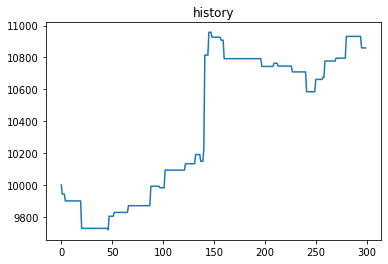

In [138]:
# 투자 히스토리
plt.plot(total_momey_list)
plt.title("history")
plt.show()

# 4. test 데이터 학습하고 추론하기

In [139]:
test_pred_array = np.zeros([test_x_array.shape[0],
                           120])
for idx in tqdm(range(test_x_array.shape[0])):
    try:
        try:
            x_series = test_x_array[idx,:,1]

            model = ARIMA(x_series, order=(5,1,1))
            fit  = model.fit()
            preds = fit.predict(1,120, typ='levels')
            test_pred_array[idx,:] = preds
        except:
            x_series = test_x_array[idx,:,1]
            model = ARIMA(x_series, order=(4,1,1))
            fit  = model.fit()
            preds = fit.predict(1,120, typ='levels')
            test_pred_array[idx,:] = preds
    except:
        print(idx, " 샘플은 수렴하지 않습니다.")
        pass

100%|██████████| 529/529 [03:31<00:00,  2.50it/s]


## 추론한 test_pred_array를 바탕으로 submission df 생성하기

In [140]:
submission = array_to_submission(test_x_array, test_pred_array)

In [141]:
submission.to_csv("baseline_submission.csv", index = False)